In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# 1) Load
flights = pd.read_csv("/content/flights.csv")
planes  = pd.read_csv("/content/planes.csv")
weather = pd.read_csv("/content/weather.csv")
#print(flights.head())
#print(planes.head())
#print(weather.head())

In [31]:

# 2) Filter time (safety check)
flights = flights[(flights["year"]==2013) & (flights["month"]==3)].copy()
#print(flights.head())


In [32]:
# 3) Identify target aircraft
planes["is_b737"] = planes["model"].astype(str).str.contains("737", na=False)
planes["is_b757"] = planes["model"].astype(str).str.contains("757", na=False)
planes["is_target"] = (planes["manufacturer"]=="BOEING") & (planes["is_b737"] | planes["is_b757"])
#print(planes.head())


In [33]:
# 4) Join flights<->planes
df = flights.merge(
    planes.loc[planes["is_target"], ["tailnum","manufacturer","model"]],
    on="tailnum",
    how="inner"   # inner: keep only identifiable B737/B757
)
#print(df.head())

In [34]:
# 5) Join df<->weather on (origin, time_hour)
df = df.merge(
    weather[["origin","time_hour","visib","wind_speed","precip","temp","pressure","humid"]],
    on=["origin","time_hour"],
    how="left"
)
#print(df.head())

In [55]:

# 6) Clean / features
df = df.dropna(subset=["dep_delay","visib"])
df["is_delayed_15"] = (df["dep_delay"] > 15).astype(int)

bins = [-np.inf, 1, 3, 6, 10]
labels = ["very_low","low","medium","good"]
df["visib_cat"] = pd.cut(df["visib"], bins=bins, labels=labels)
#print(df.head())

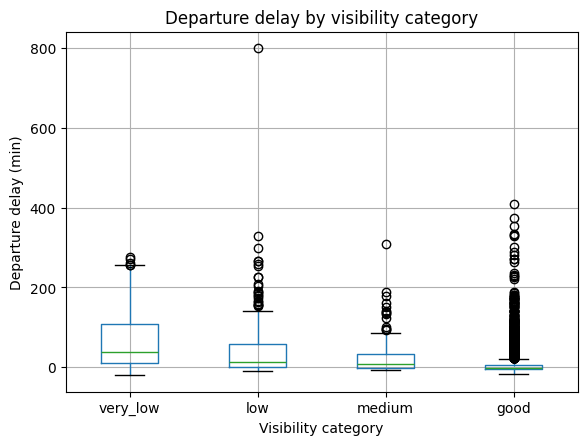

In [56]:
# 7) EDA: example boxplot
df.boxplot(column="dep_delay", by="visib_cat")
plt.suptitle("")
plt.title("Departure delay by visibility category")
plt.xlabel("Visibility category")
plt.ylabel("Departure delay (min)")
plt.show()

In [57]:
# 8) Models
ols = smf.ols(
    "dep_delay ~ visib + C(origin) + C(hour) + wind_speed + precip + temp + pressure + humid",
    data=df
).fit(cov_type="HC3")

logit = smf.logit(
    "is_delayed_15 ~ visib + C(origin) + C(hour) + wind_speed + precip + temp + pressure + humid",
    data=df
).fit(disp=False)

print(ols.summary())
print(logit.summary())


                            OLS Regression Results                            
Dep. Variable:              dep_delay   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     14.62
Date:                Tue, 17 Feb 2026   Prob (F-statistic):           7.68e-58
Time:                        09:54:10   Log-Likelihood:                -27235.
No. Observations:                5769   AIC:                         5.452e+04
Df Residuals:                    5744   BIC:                         5.469e+04
Df Model:                          24                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -165.2453     66.171  

In [60]:
# 9) Impact translation (simple scenario)
scenario = df.assign(visib=10).iloc[:500].copy()
p_good = logit.predict(scenario).mean()

scenario["visib"] = 2
p_low = logit.predict(scenario).mean()

print("ΔP(delay>15):", (p_low - p_good))


ΔP(delay>15): 0.19390938225965318


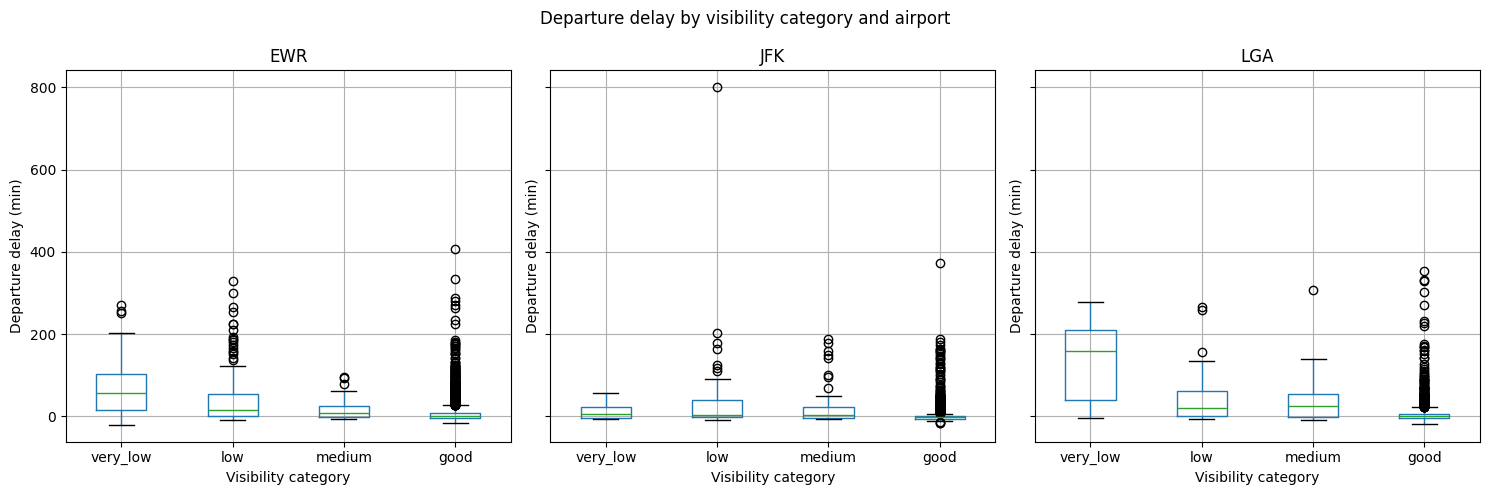

EWR
visib_cat
good        3181
low          221
very_low      63
medium        60
Name: count, dtype: int64

JFK
visib_cat
good        1424
low           63
medium        51
very_low      23
Name: count, dtype: int64

LGA
visib_cat
good        1220
low           49
medium        26
very_low      18
Name: count, dtype: int64



In [61]:
# 10) --- Facet boxplots by airport (origin) ---

origins = sorted(df["origin"].dropna().unique())
fig, axes = plt.subplots(1, len(origins), figsize=(5*len(origins), 5), sharey=True)

if len(origins) == 1:
    axes = [axes]

for ax, orig in zip(axes, origins):
    subset = df[df["origin"] == orig]
    subset.boxplot(column="dep_delay", by="visib_cat", ax=ax)
    ax.set_title(orig)
    ax.set_xlabel("Visibility category")
    ax.set_ylabel("Departure delay (min)")

plt.suptitle("Departure delay by visibility category and airport")
plt.tight_layout()
plt.show()

for orig in origins:
    print(orig)
    print(df[df["origin"] == orig]["visib_cat"].value_counts())
    print()


/tmp/ipython-input-640257075.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = subset.groupby("visib_bin")["dep_delay"].mean()
/tmp/ipython-input-640257075.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = subset.groupby("visib_bin")["dep_delay"].mean()
/tmp/ipython-input-640257075.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = subset.groupby("visib_bin")["dep_delay"].mean()


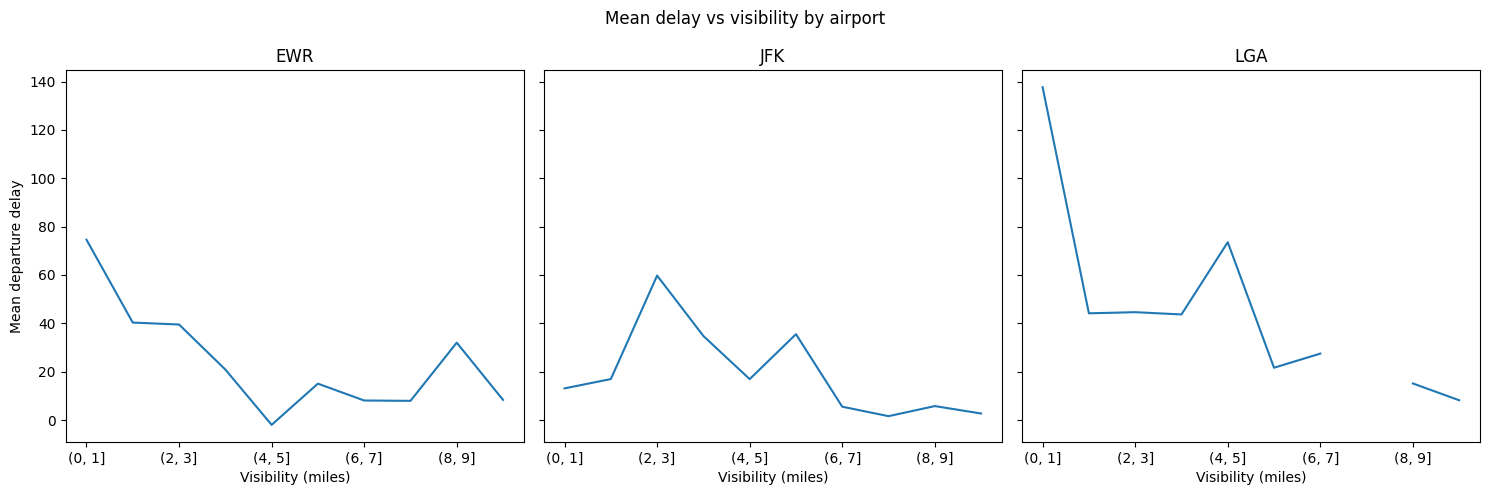

In [62]:
# 11) --- Mean delay vs visibility bins per origin ---

df["visib_bin"] = pd.cut(df["visib"], bins=np.arange(0, 21, 1))

fig, axes = plt.subplots(1, len(origins), figsize=(5*len(origins), 5), sharey=True)

for ax, orig in zip(axes, origins):
    subset = df[df["origin"] == orig]
    grp = subset.groupby("visib_bin")["dep_delay"].mean()
    grp.plot(ax=ax)
    ax.set_title(orig)
    ax.set_xlabel("Visibility (miles)")
    ax.set_ylabel("Mean departure delay")

plt.suptitle("Mean delay vs visibility by airport")
plt.tight_layout()
plt.show()


In [67]:
# 12) --- Predicted minutes table from OLS ---

# Baseline: käytä satunnaista otosta df:stä realistisilla control-arvoilla
base = df.iloc[:500].copy()

# Good visibility scenario
sc_good = base.copy()
sc_good["visib"] = 10

# Low visibility scenario
sc_low = base.copy()
sc_low["visib"] = 2

pred_good = ols.predict(sc_good).mean()
pred_low  = ols.predict(sc_low).mean()

impact_minutes = pred_low - pred_good

pred_table = pd.DataFrame({
    "Scenario": ["Good visibility (10 mi)", "Low visibility (2 mi)"],
    "Predicted mean delay (min)": [pred_good, pred_low]
})

print("\nPredicted minutes table:")
print(pred_table)
print("\nImpact (low - good):", impact_minutes, "minutes")



Predicted minutes table:
                  Scenario  Predicted mean delay (min)
0  Good visibility (10 mi)                    6.119912
1    Low visibility (2 mi)                   30.913024

Impact (low - good): 24.793112713400486 minutes


In [68]:
# 13) --- Predicted minutes table by airport from OLS ---

rows = []

for orig in origins:
    base_o = df[df["origin"] == orig].iloc[:500].copy()

    if len(base_o) == 0:
        continue

    sc_good = base_o.copy()
    sc_good["visib"] = 10

    sc_low = base_o.copy()
    sc_low["visib"] = 2

    pred_good = ols.predict(sc_good).mean()
    pred_low  = ols.predict(sc_low).mean()

    rows.append({
        "origin": orig,
        "good_visibility_delay": pred_good,
        "low_visibility_delay": pred_low,
        "impact_minutes": pred_low - pred_good
    })

pred_by_airport = pd.DataFrame(rows)
print("\nPredicted minutes by airport:")
print(pred_by_airport)



Predicted minutes by airport:
  origin  good_visibility_delay  low_visibility_delay  impact_minutes
0    EWR               8.482169             33.275282       24.793113
1    JFK               4.201058             28.994171       24.793113
2    LGA               9.605523             34.398636       24.793113


In [65]:
# 14) --- Winsorization of dep_delay ---

df_wins = df.copy()
lower = df_wins["dep_delay"].quantile(0.01)
upper = df_wins["dep_delay"].quantile(0.99)

df_wins["dep_delay_w"] = df_wins["dep_delay"].clip(lower, upper)

ols_wins = smf.ols(
    "dep_delay_w ~ visib + C(origin) + C(hour) + wind_speed + precip + temp + pressure + humid",
    data=df_wins
).fit(cov_type="HC3")

print("\nWinsorized OLS result:")
print(ols_wins.summary())



Winsorized OLS result:
                            OLS Regression Results                            
Dep. Variable:            dep_delay_w   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     16.85
Date:                Tue, 17 Feb 2026   Prob (F-statistic):           4.12e-68
Time:                        09:57:50   Log-Likelihood:                -26466.
No. Observations:                5769   AIC:                         5.298e+04
Df Residuals:                    5744   BIC:                         5.315e+04
Df Model:                          24                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept       

In [66]:
# 15) --- Quantile regression (median) ---

quant = smf.quantreg(
    "dep_delay ~ visib + C(origin) + C(hour) + wind_speed + precip + temp + pressure + humid",
    data=df
).fit(q=0.5)

print("\nQuantile regression (median) result:")
print(quant.summary())



Quantile regression (median) result:
                         QuantReg Regression Results                          
Dep. Variable:              dep_delay   Pseudo R-squared:              0.03141
Model:                       QuantReg   Bandwidth:                       1.904
Method:                 Least Squares   Sparsity:                        13.47
Date:                Tue, 17 Feb 2026   No. Observations:                 5769
Time:                        09:58:06   Df Residuals:                     5744
                                        Df Model:                           24
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -10.5771     13.990     -0.756      0.450     -38.003      16.849
C(origin)[T.JFK]    -3.2677      0.223    -14.644      0.000      -3.705      -2.830
C(origin)[T.LGA]    -0.1485      0.234     -0.634      0.526      -0.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
